# Telco Churn

In [1]:
# .py file imports 
from env import password, host, user, url
from env import sql_database
import acquire
import prepare

# Data science libraries
import pandas as pd
import numpy as np



# For exploration
from math import sqrt
from scipy import stats

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# For scaling and Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

# For modeling
import model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



# Acquire

In [2]:
# This function checks to see if the csv file already exists. If it doesn't, it will create a new csv file.

acquire.check_for_csv_file("telco_churn_data.csv")

In [3]:
# This function reads the csv data
telco = acquire.read_telco_data()

Why are customers churning?

My main hypothesis at the moment is that customers are churning because they don't see the value in our services, and as such, they are becoming very price driven. People in different contract, that don't churn after 1 month, usually have our premium packages. This is evident because only about 25% of our customers have the premium offerings

# Prepare

In [4]:
df = prepare.prep_data(telco)

# Split

In [5]:
train, validate, test = prepare.split_data(df)

In [6]:
train = prepare.encode_new_columns(train)
validate = prepare.encode_new_columns(validate)
test = prepare.encode_new_columns(test)

/Users/danielguerrero/codeup_data_science/analyzing-customer-churn/prepare.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["partner_dependents"] = df.apply(lambda row: partner_dependents(row), axis = 1)
/Users/danielguerrero/codeup_data_science/analyzing-customer-churn/prepare.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["streaming_features"] = df.apply(lambda row: streaming_features(row), axis = 1)
/Users/danielguerrero/codeup_data_science/analyzing-customer-churn/prepare.py:126: Setting

# Explore

In [7]:
explore_int = train.select_dtypes(exclude="object")

Text(0.5, 1.0, 'Churn')

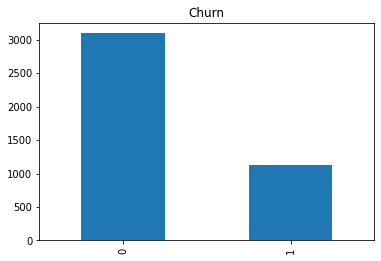

In [8]:
train.churn.value_counts().plot.bar().set_title("Churn")

In [9]:
mean_charges = train[train.churn == 1].monthly_charges.mean()
total_losses = train[train.churn == 1].monthly_charges.count()

print(f'''
On average, we are loosing {train["churn"].shape[0] / train.shape[0]:.0%} of our customers. This might not seem like a lot, but in terms of dollars, this 
means that every time a customer churns, we lose about ${mean_charges:.0f}. In otherwords, we could be potentially
loosing, on average, about ${(mean_charges * total_losses):,.0f} every month.

''')


On average, we are loosing 100% of our customers. This might not seem like a lot, but in terms of dollars, this 
means that every time a customer churns, we lose about $74. In otherwords, we could be potentially
loosing, on average, about $83,605 every month.




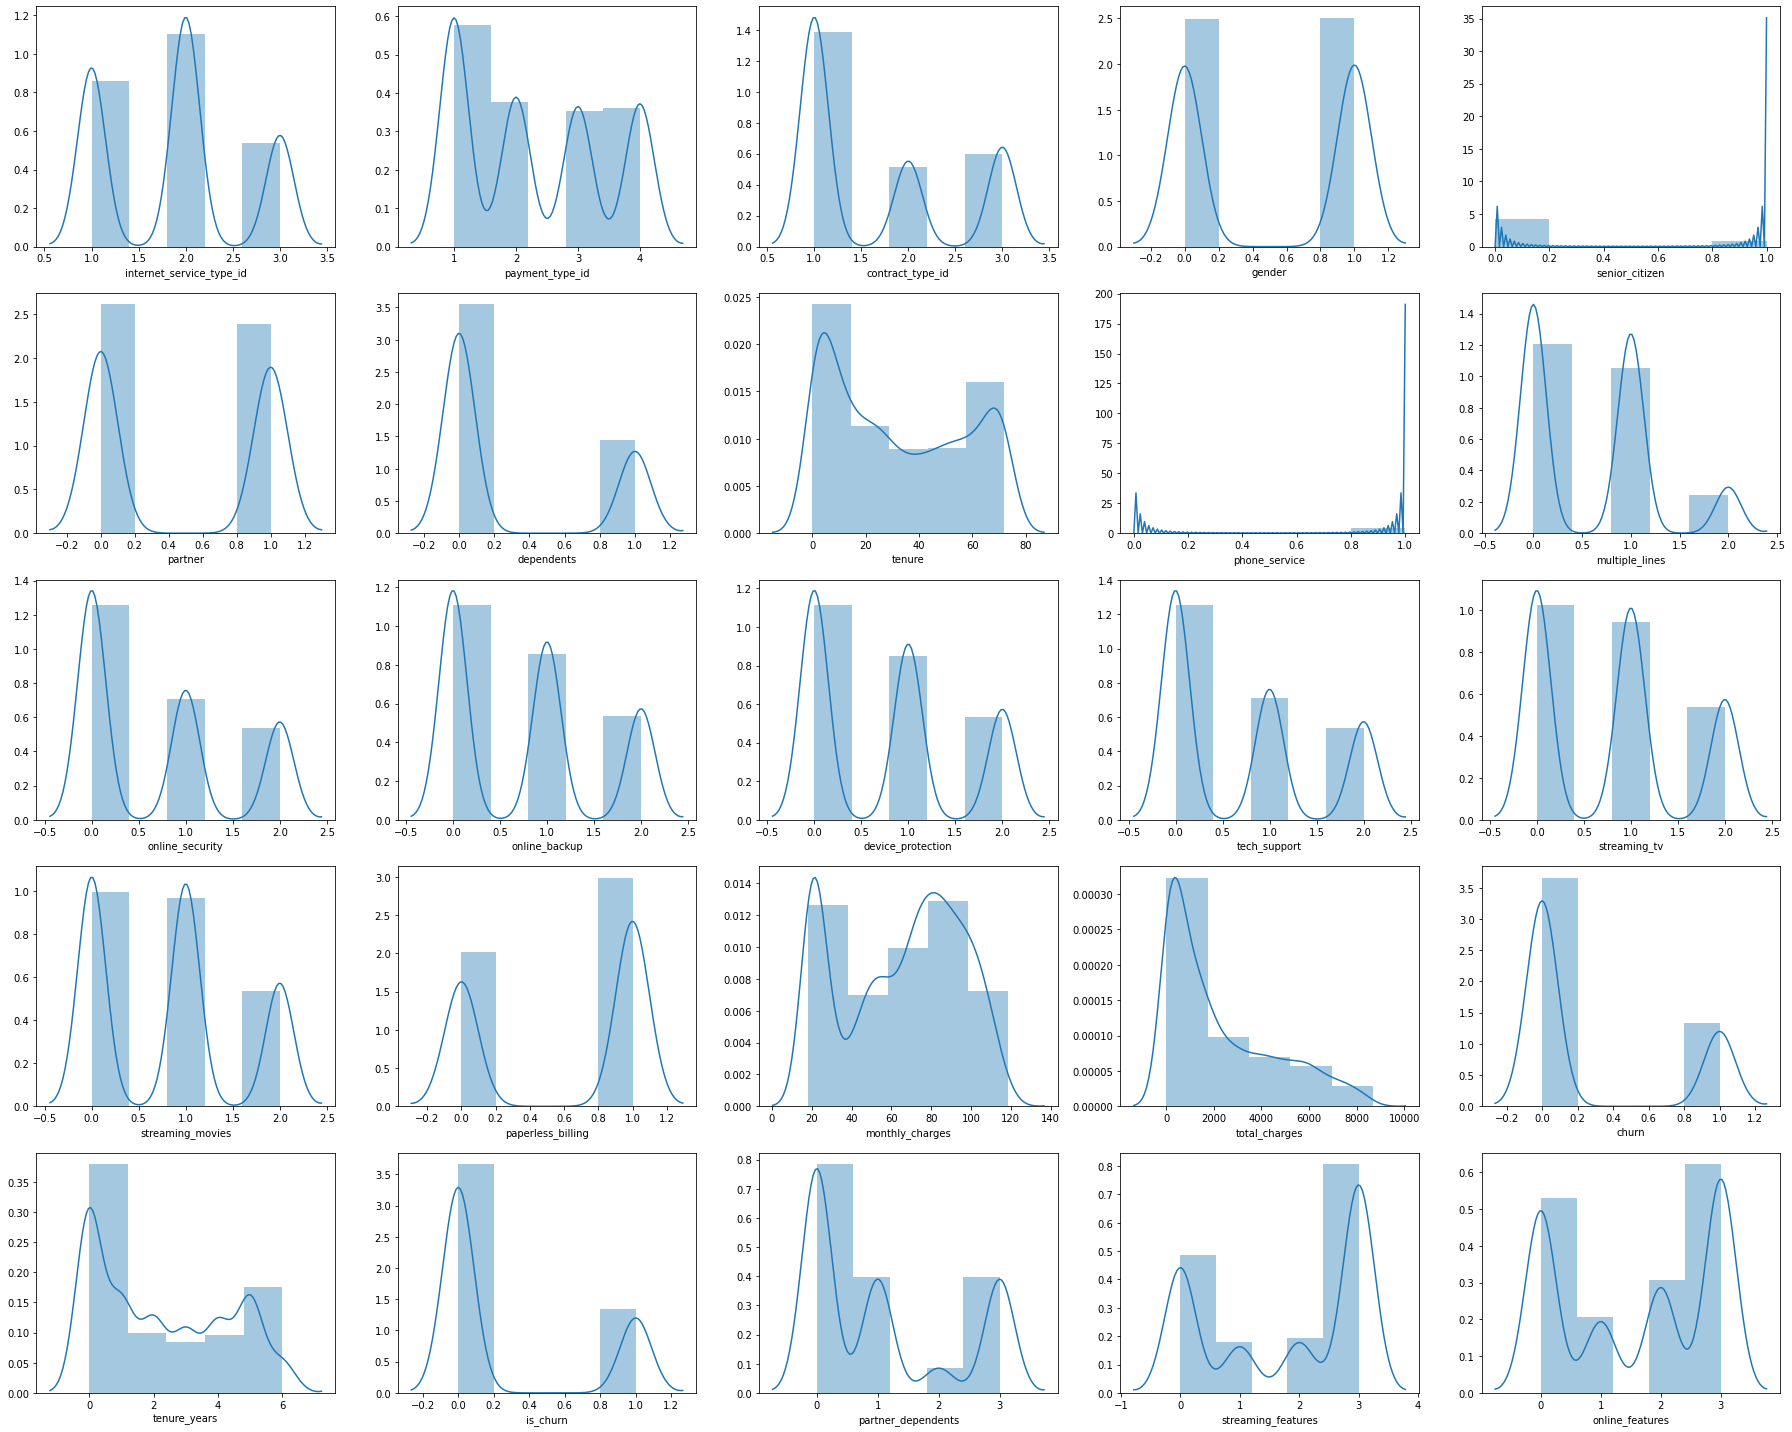

In [10]:
f = plt.figure(figsize=(25,20))
continuous_data = train.select_dtypes(include=["int", "float"])

for i in range(0,25):
    f.add_subplot(5,5, i+1)
    sns.distplot(continuous_data.iloc[:,i], bins=5)
plt.tight_layout()
plt.show()

Looking at the distribution of the data, we can see that most of the data is not normally distributed. We will do some exploration, and decide what columns to drop, before scaling using a linear scaler to evenly distribute the data. My two key take-aways at the this moment are:

1. Ocne we get to modeling, it is likely better to use `monthly_charges` than `total_charges`. Not only does `monthly_charges` has no imputted values, but also it is more normally distributed than `total_charges`, which is very right skewed. Ultimately, this could be fixed with scaling, but given that both variables are highly dependent on each other, we will need to drop one for modeling purposes anyways. 
1. `Tenure` is also not normally distributed. I suspect this will be another key feature in predicting churn, so it will likely need to be scaled. Again, `tenure` seems more normally distributed than `tenure_years`, so it is likely we chose `tenure` for modeling, given that both variables are codependent, and thus we shouldn't use both if we want to have high accuracy in our models.

## Is there a corelation between the variables?

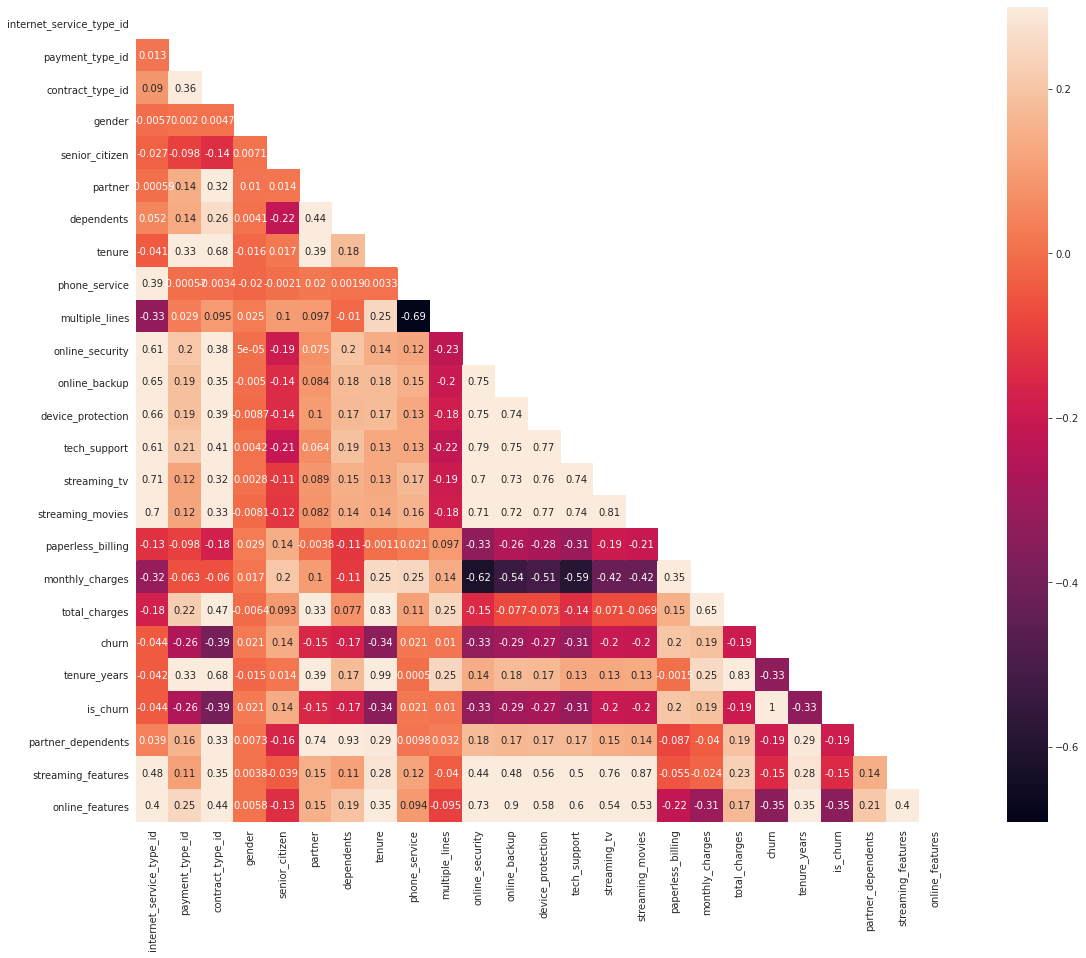

In [11]:
mask = np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
     f, ax = plt.subplots(figsize=(20, 15))
     ax = sns.heatmap(train.corr(), mask=mask, vmax=.3, square=True, annot=True)

As mentioned above, we want to have features that are completely independent of each other - as these will provide the most accurate patterns that the models can use to make predictions (with the exeption of KNN). The only features that seem to have a high correlation are `monthly_charges` with the premium features, which includes `online_security`, `online_backup`, `device_protection`, `tech_support` and streaming. This makes sense, as you would expect that the more features you have, the bigger the change in monthly price. It is a bit odd, however, that they are negatively correlated, as you would expect that as more features are added, the price per month would increase. Given that premium features can be a key indicator on whether a person might churn, we will do a pearson's r correlation test to see if the variables are independent of each other or not.

* $H_0$: There is no significant correlation between `monthly_charges` and the premium features. 
* $H_a$: There is a significant correlation between `monthly_charges` and the premium features. 

* $\alpha$ = 0.05

In [12]:
group = train[["online_security", "online_backup", "tech_support", "device_protection", "monthly_charges"]]

for col in range(0,4):
    r, p = stats.pearsonr(train.monthly_charges, train[group.columns[col]])
    if p > 0.05:
        print(f"The p value for {group.columns[col]} is higher than our alpha, and thus we fail to reject the null hypothesis")
    else:
        print(f'The p value of {group.columns[col]} is {p:.0f}')
print('''
      
Beacuse all of our p's are smaller than our alpha, so we reject the null hypothesis. This means that there
is a linear correlation between monthly_charges and all these premium categories, and thus shouldn't be used together for 
modeling

''')


The p value of online_security is 0
The p value of online_backup is 0
The p value of tech_support is 0
The p value of device_protection is 0

      
Beacuse all of our p's are smaller than our alpha, so we reject the null hypothesis. This means that there
is a linear correlation between monthly_charges and all these premium categories, and thus shouldn't be used together for 
modeling




Another two variables that we want to check whether are highly correlated (and we would expect them to be) is monthly_charges and total_charges

* $H_0$: There is no significant correlation between `monthly_charges` and `total_charges`. 
* $H_a$: There is a significant correlation between `monthly_charges` and `total_chages`. 

* $\alpha$ = 0.05

In [149]:
r, p = stats.pearsonr(train.monthly_charges, train.total_charges)

p

0.0

As expected - our p value is 0, which is smaller than our alpha, and thus we know that we shouldn't use both `total_charges` and `monthly_charges` together for modeling.

## Are there clear groupings where a customer is more likely to churn?

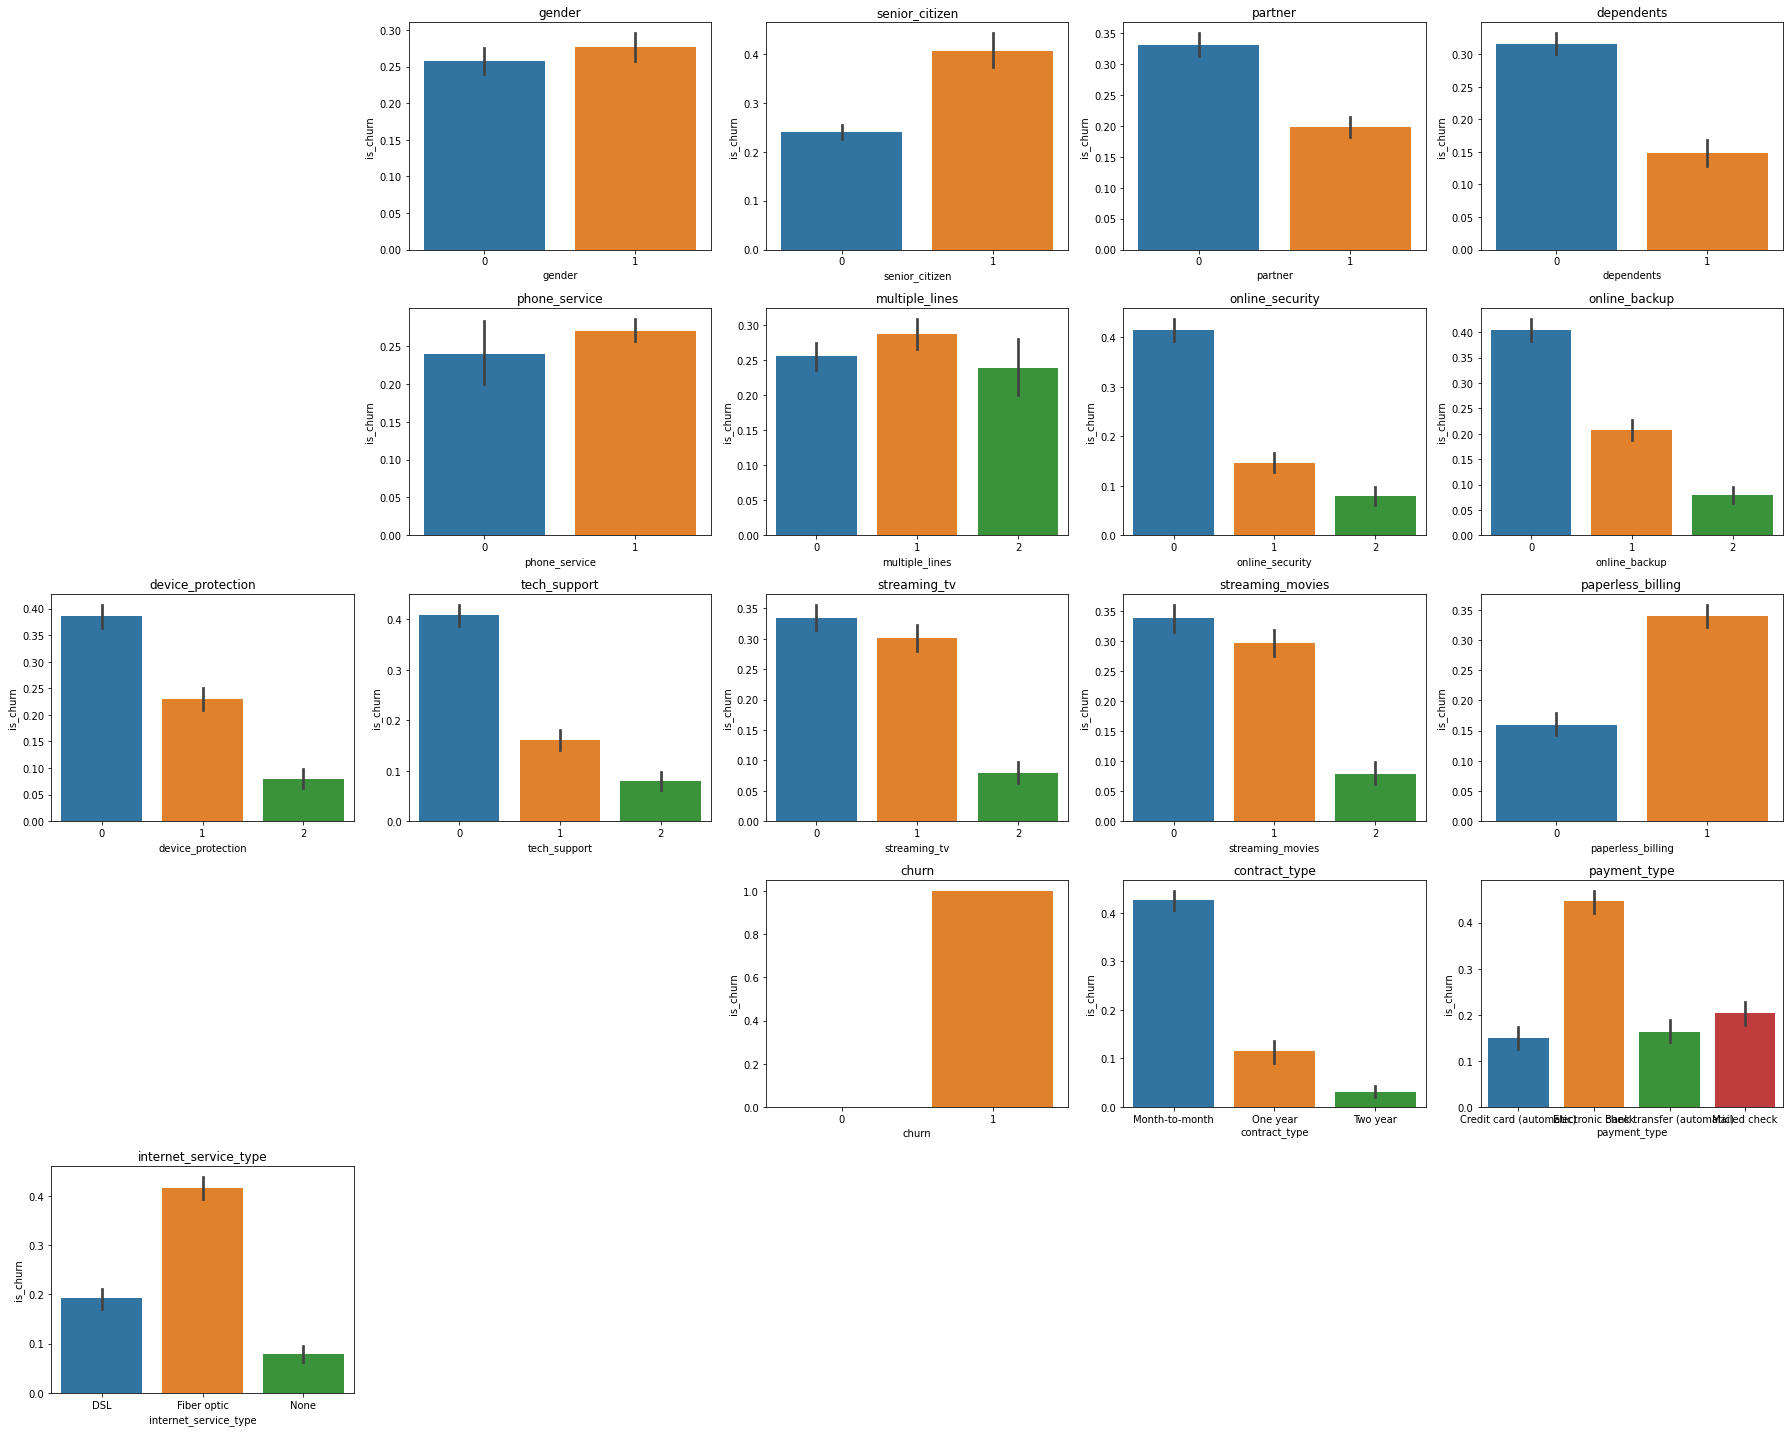

In [13]:
f = plt.figure(figsize=(25,20))

for i in range(0,21):
    if len(train.groupby(train.iloc[:,i+3])) < 5:
        f.add_subplot(5,5, i+1)
        sns.barplot(data=train, y="is_churn", x=train.iloc[:,i+3])
        plt.title(train.columns[i+3])
plt.tight_layout()
plt.show()

Are there clear groupings where a customer is more likely to churn?

There are actually quite a lot of groupings that can serve as an indicator of churn. It might be too many, however, and some new features might need to be engineered. 

From what we can see - the features that at this point don't seem to have any major differences are:

* `gender`
* `phone_service`
* `multiple_lines`
* `streaming_service`

The features that seems to be some of the best indicators are:

* `payment_type`
* `contract_type`
* `internet_service_type`
* `dependents`
* `partner`

Other features that are worth investigating are:

* `online_security`
* `tech_support`
* `senior_citizen` 
* `device_protection`

These features (with the exclusion of `senior_citizen`) seem to be additional commodities that are offered, and clients that usually take up on these features seem to be less likely to churn. While this might not be as useful for modeling, this can is something that can be used as a potential metric to improve customer rentention. 

It is important first to understand what percentage of the customer population actually has these features.

In [14]:
train[train["online_security"]== 1].customer_id.value_counts().sum() / train.shape[0]

0.2835502958579882

So about 28% of the customer population has opted in for online_security, which is actually higher than I initially suspected, and means it could be a good metric for modeling afterall.

In [15]:
train[train["tech_support"]== 1].customer_id.value_counts().sum() / train.shape[0]

0.2849704142011834

In [16]:
# Does this population overlap a lot? 

tech_support = train["tech_support"]== 1
security = train["online_security"]== 1

train[tech_support & security].customer_id.value_counts().sum() / train.shape[0]

0.15171597633136094

It doesn't seem that individuals have multiple "premium" features, as only 15% of the customer population has both options.

In [17]:
## At this point, we speculate that payment_type and contract_type have some of the bigger impact in customer churning. I will do a t-test to compare if there is a significant different.

# Below is a one-tail t test for all contract types:
for i in range(0,3):
    x = train[train.contract_type == train.contract_type.unique()[0 + i]].is_churn
    mu = train.is_churn.mean()

    t_stat, p = stats.ttest_1samp(x, mu)
    
    print(f"Contract Type = {train.contract_type.unique()[0 + i]}")
    print(f't = {t_stat:.3}')
    print(f'p = {p:.10f}')
    print()

Contract Type = Month-to-month
t = 15.5
p = 0.0000000000

Contract Type = One year
t = -14.1
p = 0.0000000000

Contract Type = Two year
t = -42.9
p = 0.0000000000



In [18]:
df[df.device_protection == 2].device_protection

5517    2
5518    2
5519    2
5520    2
5521    2
       ..
7038    2
7039    2
7040    2
7041    2
7042    2
Name: device_protection, Length: 1526, dtype: int64

In [19]:
telco.tech_support

0                        No
1                       Yes
2                        No
3                        No
4                        No
               ...         
7038    No internet service
7039    No internet service
7040    No internet service
7041    No internet service
7042    No internet service
Name: tech_support, Length: 7043, dtype: object

In [20]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?

group = ["online_security", "online_backup", "tech_support", "device_protection"]


pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="mean")

churn                                                                 0  \
online_security online_backup tech_support device_protection              
0               0             0            0                  64.264348   
                                           1                  77.810473   
                              1            0                  70.027670   
                                           1                  74.791748   
                1             0            0                  72.071067   
                                           1                  84.838028   
                              1            0                  77.339109   
                                           1                  89.859091   
1               0             0            0                  65.048485   
                                           1                  71.322436   
                              1            0                  64.100000   
                                           1                  80.074609   
                1             0            0                  72.972072   
                                           1                  84.613136   
                              1            0                  74.647170   
                                           1                  90.617096   
2               2             2            2                  21.199460   

churn                                                                 1  
online_security online_backup tech_support device_protection             
0               0             0            0                  70.307551  
                                           1                  82.483740  
                              1            0                  73.658511  
                                           1                  90.939744  
                1             0            0                  77.894175  
                                           1                  94.065663  
                              1            0                  79.621667  
                                           1                  92.889474  
1               0             0            0                  71.742857  
                                           1                  85.995238  
                              1            0                  78.632353  
                                           1                  84.503125  
                1             0            0                  78.700000  
                                           1                  90.797222  
                              1            0                  89.092857  
                                           1                  97.790909  
2               2             2            2                  20.320833

In [21]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?
group = ["online_security", "online_backup", "tech_support", "device_protection"]
pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="count")

churn                                                           0    1
online_security online_backup tech_support device_protection          
0               0             0            0                  345  437
                                           1                  148  123
                              1            0                  103   47
                                           1                  103   39
                1             0            0                  178  103
                                           1                  142   83
                              1            0                  101   30
                                           1                  121   19
1               0             0            0                  132   56
                                           1                   78   21
                              1            0                   77   17
                                           1                  128   16
                1             0            0                  111   23
                                           1                  118   18
                              1            0                  106   14
                                           1                  272   11
2               2             2            2                  833   72

In [22]:
# Is there a difference in the number of ppl that have premium plans between the different contract types?

pd.pivot_table(train, index=group, columns="contract_type", values="monthly_charges")

contract_type                                                 Month-to-month  \
online_security online_backup tech_support device_protection                   
0               0             0            0                       67.571477   
                                           1                       80.008685   
                              1            0                       70.139189   
                                           1                       80.439706   
                1             0            0                       73.596121   
                                           1                       89.883462   
                              1            0                       73.073387   
                                           1                       89.029688   
1               0             0            0                       66.386667   
                                           1                       75.703846   
                              1            0                       70.472917   
                                           1                       82.881250   
                1             0            0                       71.622436   
                                           1                       82.640278   
                              1            0                       76.335938   
                                           1                       89.071429   
2               2             2            2                       20.431447   

contract_type                                                  One year  \
online_security online_backup tech_support device_protection              
0               0             0            0                  67.227273   
                                           1                  79.135556   
                              1            0                  75.300000   
                                           1                  74.302439   
                1             0            0                  76.683333   
                                           1                  88.215217   
                              1            0                  80.698684   
                                           1                  90.327778   
1               0             0            0                  71.979310   
                                           1                  71.578750   
                              1            0                  65.232258   
                                           1                  81.610465   
                1             0            0                  78.867073   
                                           1                  89.112766   
                              1            0                  75.140244   
                                           1                  90.428409   
2               2             2            2                  20.866514   

contract_type                                                  Two year  
online_security online_backup tech_support device_protection             
0               0             0            0                  84.087500  
                                           1                  81.423077  
                              1            0                  70.995455  
                                           1                  82.845455  
                1             0            0                  78.680000  
                                           1                  80.105769  
                              1            0                  83.961290  
                                           1                  90.859524  
1               0             0            0                  62.066667  
                                           1                  77.672500  
                              1            0                  57.836667  
                                           1                  79.262338  
                1

In [23]:
pd.pivot_table(train, index=group, columns="contract_type", values="monthly_charges", aggfunc="count")

contract_type                                                 Month-to-month  \
online_security online_backup tech_support device_protection                   
0               0             0            0                             745   
                                           1                             213   
                              1            0                             111   
                                           1                              68   
                1             0            0                             232   
                                           1                             130   
                              1            0                              62   
                                           1                              32   
1               0             0            0                             150   
                                           1                              39   
                              1            0                              48   
                                           1                              24   
                1             0            0                              78   
                                           1                              36   
                              1            0                              32   
                                           1                              21   
2               2             2            2                             318   

contract_type                                                 One year  \
online_security online_backup tech_support device_protection             
0               0             0            0                        33   
                                           1                        45   
                              1            0                        28   
                                           1                        41   
                1             0            0                        39   
                                           1                        69   
                              1            0                        38   
                                           1                        45   
1               0             0            0                        29   
                                           1                        40   
                              1            0                        31   
                                           1                        43   
                1             0            0                        41   
                                           1                        47   
                              1            0                        41   
                                           1                        44   
2               2             2            2                       218   

contract_type                                                 Two year  
online_security online_backup tech_support device_protection            
0               0             0            0                         4  
                                           1                        13  
                              1            0                        11  
                                           1                        33  
                1             0            0                        10  
                                           1                        26  
                              1            0                        31  
                                           1                        63  
1               0             0            0                         9  
                                           1                        20  
                              1            0                        15  
                                           1                        77  
                1             0            0      

Because the p-value for all is lower than our alpha ($\alpha = 0.05$), we know there is a significant difference in t-test between all of our contract types, and the mean. That being said, this is a very large data set, and a small p was expected. 

### Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

* $H_0$: There no difference in price for customers that have churn (when controlling for services) versus those that haven't churn.

* $H_a$: There is a difference in price for customers that have churn (when controlling for services) versus those that haven't churn.

$\alpha$ = 0.05

In [24]:
phone_id = train.phone_service == 1
internet = train.internet_service_type_id == 1
security = train.online_features == 0
support = train.tech_support == 0
device = train.device_protection == 0
contract = train.contract_type_id == 1
churn = train.is_churn == 1


x1 = train[phone_id & internet & security & support & device & contract & churn].monthly_charges
x2 = train[phone_id & internet & security & support & device & contract & ~churn].monthly_charges

t, p = stats.ttest_ind(x1,x2)

print(f"t = {t}")
print(f"p = {p:.6f}")

t = 0.1527237445184859
p = 0.878802


We see that in this case, we fail to reject the null hypothesis, as the mean monthly charges for customers that have churned versus customers that haven't churned are not significantly different. This means that customers aren't necesarly churning for price sensitive reasons. 

## Is there a significant difference in monthly charges between customers that use automatic banking?

* $H_0$: There no difference in churn rate for customers that use automatic payments.

* $H_a$: There is a difference in churn rate for customers that use automatic payments.

$\alpha$ = 0.05

In [25]:
train.payment_type

440       Credit card (automatic)
67               Electronic check
600       Credit card (automatic)
4883      Credit card (automatic)
1258    Bank transfer (automatic)
                  ...            
1794      Credit card (automatic)
817                  Mailed check
901              Electronic check
1987    Bank transfer (automatic)
6958    Bank transfer (automatic)
Name: payment_type, Length: 4225, dtype: object

In [26]:
card = train.payment_type == "Credit card (automatic)"
bank = train.payment_type == "Bank transfer (automatic)" 
automatic_banking = card | bank
churn = train.is_churn == 1

x1 = train[automatic_banking].is_churn
x2 = train[~automatic_banking].is_churn

t, p = stats.ttest_ind(x1,x2)

print(f"t = {t}")
print(f"p = {p:.6f}")

t = -14.400519026868128
p = 0.000000


In [27]:
x1 = train[automatic_banking].is_churn.mean()
x2 = train[~automatic_banking].is_churn.mean()

if x1 < x2:
    print("On average, there is a significant difference in churn rate between customers that use the automatic payment methods, versus those who didn't")
else: 
    print("There is no significant difference in churn rate")

On average, there is a significant difference in churn rate between customers that use the automatic payment methods, versus those who didn't


Because our p-value is smaller than our alpha - we can reject the null hypothesis.

## Is there a tenure that month-to-month customers are most likely to churn

In [28]:
train.groupby(["is_churn", "contract_type"]).tenure.mean()

is_churn  contract_type 
0         Month-to-month    20.236960
          One year          40.900259
          Two year          56.945010
1         Month-to-month    13.606820
          One year          47.200000
          Two year          60.406250
Name: tenure, dtype: float64

In [29]:
for i in range(0, 3):
    print(f'''
    The average number of months we retain a customer on a {train.contract_type.unique()[0 + i]} contract is: {train[train["contract_type"] == train.contract_type.unique()[0 + i]].tenure.mean():.2f}
    '''
    )


    The average number of months we retain a customer on a Month-to-month contract is: 17.41
    

    The average number of months we retain a customer on a One year contract is: 41.62
    

    The average number of months we retain a customer on a Two year contract is: 57.05
    


In [30]:
# How many ppl are in each contract type?

train.groupby("contract_type").contract_type.count()

contract_type
Month-to-month    2339
One year           872
Two year          1014
Name: contract_type, dtype: int64

The majority of customers are on a one-month contract. Which means that this is the "leacky bucket".

In [31]:
# What is the total revenue, by contract?

train.groupby("contract_type").total_charges.mean()

contract_type
Month-to-month    1313.218384
One year          3013.493463
Two year          3774.870858
Name: total_charges, dtype: float64

Not surprisingly, the majority of the revenue comes from customers in two-year contracts. THese are the high value targets. The revenue from monthly customers is also substancial, and this acrtually is likely to have the most room for improvement, given that the churn is so high.

In [32]:
train[train["contract_type"] == "Month-to-month"].groupby("tenure").is_churn.agg(["mean", "sum"]).nlargest(15, columns="sum")

,mean,sum
tenure,,
1,0.612299,229
2,0.496599,73
3,0.466667,56
4,0.481132,51
5,0.481481,39
7,0.476923,31
9,0.461538,30
10,0.491803,30
8,0.426230,26


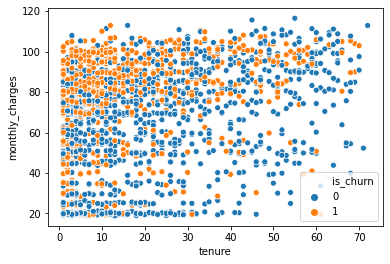

In [33]:
sns.scatterplot(data=train[train.contract_type == "Month-to-month"], x="tenure", y="monthly_charges", hue="is_churn")

Interesting finding - about 852 ppl are churning after the first 5 months for customers that have a monthly contract. It doesn't seem that price alone is the main driver, as there are plently of users that are paying in near the upper bound and aren't churning.

Do customers that churn after the first month have premium offerings?

In [34]:
tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that churned on a Month-to-month contract during the first 5 months")
for i in range(0,4):
    feature = train[group.columns[i]] == 1
    print(group.columns[i])
    print(f"{train[tenure & churn & feature & contract][group.columns[i]].sum()}, out of {train[tenure & churn & contract].shape[0]}")
    print()


Customers that churned on a Month-to-month contract during the first 5 months
online_security
35, out of 448

online_backup
52, out of 448

tech_support
43, out of 448

device_protection
61, out of 448



In [35]:
tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that didn't churn on a Month-to-month contract after 5 months")
for i in range(0,4):
    feature = train[group.columns[i]] == 1
    print(group.columns[i])
    print(f"{train[tenure & ~churn & feature & contract][group.columns[i]].sum()}, out of {train[tenure & churn & contract].shape[0]}")
    print()

Customers that didn't churn on a Month-to-month contract after 5 months
online_security
50, out of 448

online_backup
53, out of 448

tech_support
45, out of 448

device_protection
34, out of 448



In [36]:
train.payment_type

440       Credit card (automatic)
67               Electronic check
600       Credit card (automatic)
4883      Credit card (automatic)
1258    Bank transfer (automatic)
                  ...            
1794      Credit card (automatic)
817                  Mailed check
901              Electronic check
1987    Bank transfer (automatic)
6958    Bank transfer (automatic)
Name: payment_type, Length: 4225, dtype: object

In [37]:
# What about for payment methods?

tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that churned on a Month-to-month contract during the first 5 months")
for i in range(0,4):
    payment = train.payment_type == train.payment_type.unique()[0 + i]
    print(train.payment_type.unique()[0 + i])
    print(f"{train[tenure & churn & contract & payment].shape[0]}, out of {train[tenure & churn & contract].shape[0]}")
    print()


Customers that churned on a Month-to-month contract during the first 5 months
Credit card (automatic)
27, out of 448

Electronic check
264, out of 448

Bank transfer (automatic)
31, out of 448

Mailed check
126, out of 448



In [38]:
# What about for payment methods?

tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that churned on a Month-to-month contract during the first 5 months")
for i in range(0,4):
    payment = train.payment_type == train.payment_type.unique()[0 + i]
    print(train.payment_type.unique()[0 + i])
    print(f"{train[tenure & ~churn & contract & payment].shape[0]}, out of {train[tenure & ~churn & contract].shape[0]}")
    print()

Customers that churned on a Month-to-month contract during the first 5 months
Credit card (automatic)
38, out of 380

Electronic check
140, out of 380

Bank transfer (automatic)
27, out of 380

Mailed check
175, out of 380



In [39]:
# What is the payment method distribution?

train.payment_type.value_counts()

Electronic check             1462
Mailed check                  955
Credit card (automatic)       913
Bank transfer (automatic)     895
Name: payment_type, dtype: int64

In [40]:
pd.pivot_table(train, index=["senior_citizen", "dependents", "gender", "partner"], values="monthly_charges", columns="payment_type")

payment_type                              Bank transfer (automatic)  \
senior_citizen dependents gender partner                              
0              0          0      0                        63.639041   
                                 1                        71.759524   
                          1      0                        65.775000   
                                 1                        69.592268   
               1          0      0                        48.100000   
                                 1                        65.665487   
                          1      0                        57.042857   
                                 1                        64.776582   
1              0          0      0                        66.602000   
                                 1                        81.424468   
                          1      0                        82.308621   
                                 1                        85.755172   
               1          0      0                              NaN   
                                 1                        58.350000   
                          1      0                              NaN   
                                 1                        73.462500   

payment_type                              Credit card (automatic)  \
senior_citizen dependents gender partner                            
0              0          0      0                      60.071831   
                                 1                      70.337931   
                          1      0                      63.452961   
                                 1                      74.393548   
               1          0      0                      52.437931   
                                 1                      64.953516   
                          1      0                      59.205769   
                                 1                      63.785081   
1              0          0      0                      66.580769   
                                 1                      74.610294   
                          1      0                      83.263333   
                                 1                      87.456452   
               1          0      0                      94.800000   
                                 1                      84.775000   
                          1      0                            NaN   
                                 1                      91.487500   

payment_type                              Electronic check  Mailed check  
senior_citizen dependents gender partner                                  
0              0          0      0               71.618089     40.825781  
                                 1               83.131780     56.278302  
                          1      0               71.175493     43.561239  
                                 1               78.091453     51.956897  
               1          0      0               69.104839     37.512222  
                                 1               73.179048     40.806579  
                          1      0               70.277500     43.298438  
                                 1               71.386893     36.831933  
1              0          0      0               79.323295     64.835000  
                                 1               86.715132     60.271429  
                          1      0               76.620492     53.304545  
                                 1               84.633594     54.221429  
               1          0      0                     NaN     80.450000  
                                 1               87.400000     67.000000  
                          1      0              101.300000           NaN  
                                 1               82.850000     61.150000

My new theory is that payment method is likely to be the best reason why customers churn, along with other potential reasons. This means to indicate that customers not on automatic payments are more likely to churn. There is not one particular demographic that is more likely to use the electronic check, which leads me to believe this can be a good indicator of churn probability.

## Is there a tenure that one year customers are most likely to churn

In [41]:
train[train["contract_type"] == "One year"].groupby("tenure").is_churn.agg(["mean", "sum"]).nlargest(15, columns="sum")

,mean,sum
tenure,,
58,0.315789,6
67,0.285714,6
53,0.200000,5
48,0.285714,4
54,0.266667,4
66,0.181818,4
39,0.272727,3
45,0.250000,3
46,0.272727,3


In [42]:
tenure = train.tenure == 12
contract = train.contract_type == "One year"

train[tenure & contract].is_churn.sum()

2

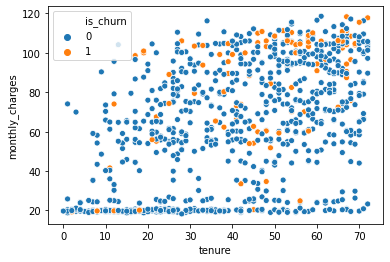

In [43]:
sns.scatterplot(data=train[train.contract_type == "One year"], x="tenure", y="monthly_charges", hue="is_churn")

Weirdly - is doesn't seem that there are a lot of customers that are churning after 12 months, which is what you would expect. 

Not as many people churning on one-year contracts (~230). They are the smallest group. There is no particular tenure month that seems to have the highest churn rate.

## ## Is there a tenure that two year customers are most likely to churn

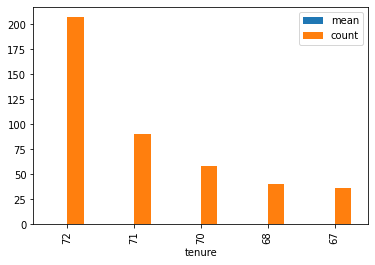

In [44]:
train[train["contract_type"] == "Two year"].groupby("tenure").is_churn.agg(["mean", "count"]).nlargest(5, columns="count").plot.bar()

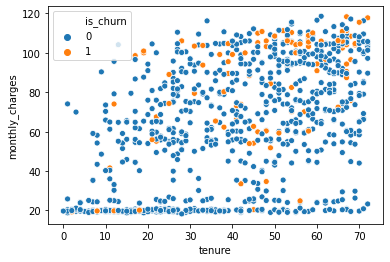

In [45]:
sns.scatterplot(data=train[train.contract_type == "One year"], x="tenure", y="monthly_charges", hue="is_churn")

It seems that most customers on two -year contracts begin to churn after 70 months or more. Other than that, it seems fairly low. 

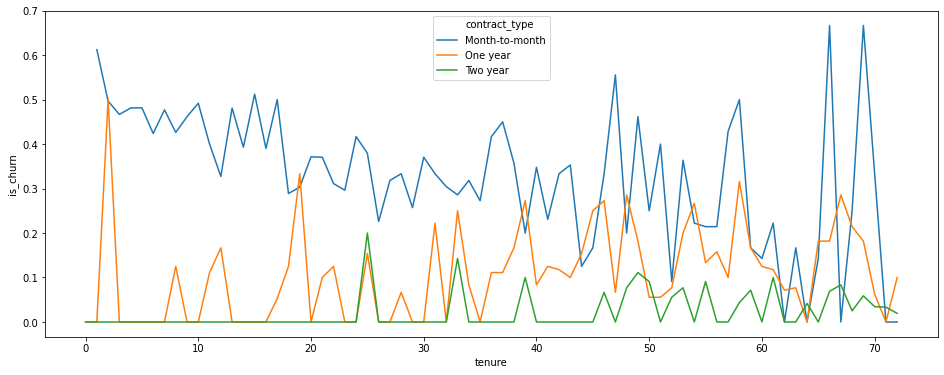

In [46]:
plt.figure(figsize=(16,6))
sns.lineplot('tenure', 'is_churn', hue='contract_type', data=train, ci=None)

## If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

$churn\_rate = \frac{(n\_users_0 - n\_users_n)}{n_users_0}$
$for \  _n \ months$

In [47]:
contract = train.contract_type == "Month-to-month"
no_churn = train.churn == "No"
tenure = train.tenure <= 12


churn_rate_m = (train[contract & tenure].shape[0] - train[contract & no_churn & tenure].shape[0]) / train[contract & tenure].shape[0]

In [48]:
contract = train.contract_type == "One year"
no_churn = train.churn == "No"
tenure = train.tenure <= 12

churn_rate_1 = (train[contract & tenure].shape[0] - train[contract & no_churn & tenure].shape[0]) / train[contract & tenure].shape[0]

In [49]:
print(f'''

After the 12th month, the churn rate for customers on a month-to-month plan is {churn_rate_m:.1%}, while for customers on a 1-year plan is {churn_rate_1:.1%}

The clearly tells us that the churn rate is not comparable between both services. The key-takeway here is that we need to convert more month-to-month customers into yearly customers, as they are less likely to churn
''')



After the 12th month, the churn rate for customers on a month-to-month plan is 100.0%, while for customers on a 1-year plan is 100.0%

The clearly tells us that the churn rate is not comparable between both services. The key-takeway here is that we need to convert more month-to-month customers into yearly customers, as they are less likely to churn



## Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).

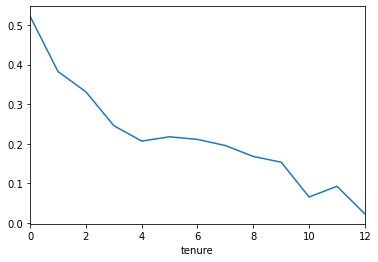

In [50]:
train.groupby(train.tenure // 6).is_churn.mean().plot()

## Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [51]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?
group = ["online_security", "online_backup", "tech_support", "device_protection"]
pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="count").reset_index()

churn,online_security,online_backup,tech_support,device_protection,0,1
0,0,0,0,0,345,437
1,0,0,0,1,148,123
2,0,0,1,0,103,47
3,0,0,1,1,103,39
4,0,1,0,0,178,103
5,0,1,0,1,142,83
6,0,1,1,0,101,30
7,0,1,1,1,121,19
8,1,0,0,0,132,56
9,1,0,0,1,78,21


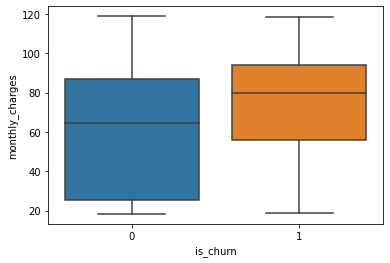

In [52]:
# Are there any outliers that could be throwing off the data?

sns.boxplot(data=train, x="is_churn", y="monthly_charges")

There don't seem to be any outliers. I does seem that customers that churn had on average a higher monthly charges. We know that when control for some of the services, the monthly_charges is not significantly different, but that the graph above shows that there could be some other features that are spiking the price for some customers, and this new price might be driving customers to churn.

# Scaling

Now that the exploration is done - we need to start scaling the data so that we can model it.

In [53]:
X_train, X_validate, X_test = prepare.prep_for_modeling(train, validate, test)

In [54]:
y_train = train.is_churn
y_validate = validate.is_churn
y_test = test.is_churn

In [55]:
# We make sure that the data is still what we think it is, by ensuring that 
# our data shape is still accurate

assert(X_train.shape[0] == train.shape[0])
assert(X_validate.shape[0] == validate.shape[0])
assert(X_test.shape[0] == test.shape[0])

assert(y_train.shape[0] == train.shape[0])
assert(y_validate.shape[0] == validate.shape[0])
assert(y_test.shape[0] == test.shape[0])

# Modeling

Before begining to model - I will write down all the possible outcomes, to help us. 

In this case, becasue we are trying to predict the customers that will churn, our **our positive values == churn, or 1**.

The possible outcomes:

TP: Predict that a customer will churn, and it churns
TN: Predict that a customer will not churn, and it doesn't churn
FP: Predict that a customer will churn, and it doesn't churn
FN: Predict that a customer will not churn, and it churn.

In this case, because we are trying to identify customers that are churning, we want to minimize the number of FN in our predictions, because it is more expensive to predict that a customer will not churn, and it churns, than it is to predict that a customer will churn, and in reality it wasn't going to churn. 

The cost difference comes from the potential value of a customer, plus the cost of then acquiring a customer to replace it (which according to a Harvard study, it can cost as much as 10 times more to acquire a new customer than it is to retain one). 

The cost of identifying a FP, is we think they will churn, so we spend time and resources trying to get it not to churn, but in reality those resources are wasted because the customer was likely not going to churn anyways. 

This is why we will focus on having a model with a high **recall** score, because this will help select a model that minimizes FN. At the same time, however, we can't afford to assume that all customer will churn, so our **precision** score also has to be relatively high.

In [56]:
# We create a new dataframe to store the predicted values from all the models. 
# This makes it significantly easier to compare our model's performances against the actual values, 
# and the baseline.

evaluation = pd.DataFrame({"actual": y_train})
evaluation["baseline"] = 0

In [57]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(evaluation.actual, evaluation.baseline), index = labels, columns = labels)
matrix

,0,1
0,3096,0
1,1129,0


We chose the baseline to be *no churn or "0"* because that is the most common value found in our target variable. As such, we will be comparing our model's effectiveness against whether they perform better than if we just assume that none of our customers will churn. Because our baseline only predicts 0, if we were to look at money saved (assuming that we could retain all customers identified as likely to churn), our baseline would cost us $83,605 a month, which is how much money we are currently loosing every month with customers that are churning.

### Logistic Regression

In [58]:
telco = acquire.read_telco_data()

In [59]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [60]:
logict, y_pred = model.run_lg(X_train, y_train)
evaluation["logistic_regression_1"] = y_pred

In [61]:
accuracy_score, matrix, report = model.accuracy_report(logict, y_pred, y_train)

In [62]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.80
      0    1
0  2791  305
1   531  598


,0,1,accuracy,macro avg,weighted avg
precision,0.840157,0.662237,0.80213,0.751197,0.792613
recall,0.901486,0.529672,0.80213,0.715579,0.802130
f1-score,0.869741,0.588583,0.80213,0.729162,0.794610
support,3096.000000,1129.000000,0.80213,4225.000000,4225.000000


### Decision Tree Classifier

In [63]:
for i in range(1,26):
    clf, y_pred = model.run_clf(X_train, y_train, i)
    print(f'max_depth = {i}, train_accuracy = {clf.score(X_train, y_train):.2%}, diff_accuracy = {(clf.score(X_train, y_train) - clf.score(X_validate, y_validate))/clf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 74.89%, diff_accuracy = -1%
max_depth = 3, train_accuracy = 78.30%, diff_accuracy = -2%
max_depth = 4, train_accuracy = 79.05%, diff_accuracy = -2%
max_depth = 5, train_accuracy = 79.69%, diff_accuracy = -1%
max_depth = 6, train_accuracy = 80.33%, diff_accuracy = 1%
max_depth = 7, train_accuracy = 81.49%, diff_accuracy = 2%
max_depth = 8, train_accuracy = 82.49%, diff_accuracy = 4%
max_depth = 9, train_accuracy = 84.05%, diff_accuracy = 8%
max_depth = 10, train_accuracy = 85.33%, diff_accuracy = 9%
max_depth = 11, train_accuracy = 86.56%, diff_accuracy = 12%
max_depth = 12, train_accuracy = 88.19%, diff_accuracy = 15%
max_depth = 13, train_accuracy = 89.94%, diff_accuracy = 20%
max_depth = 14, train_accuracy = 91.72%, diff_accuracy = 22%
max_depth = 15, train_accuracy = 93.04%, diff_accuracy = 26%
max_depth = 16, train_accuracy = 94.22%, diff_accuracy = 27%
max_depth = 17, train_accuracy = 95.36

The danger with Decision tree is that it can very easily become over fit. With the loop above, we can see all the different accuracy scores for many different values for `max_depth`. Based on the information, we want to keep a train accuracy as high as possible, while still ensuring that the model is not overfit. If we choose a `max_depth` of 10, we can get an accuracy of 85%, and keep the difference between train and validate samples relatively small.

In [64]:
clf, y_pred = model.run_clf(X_train, y_train, 10)
evaluation["decision_tree_model"] = y_pred

In [65]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)

In [66]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.85
      0    1
0  2795  301
1   319  810


,0,1,accuracy,macro avg,weighted avg
precision,0.897559,0.729073,0.853254,0.813316,0.852537
recall,0.902778,0.717449,0.853254,0.810113,0.853254
f1-score,0.900161,0.723214,0.853254,0.811688,0.852878
support,3096.000000,1129.000000,0.853254,4225.000000,4225.000000


In [67]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(evaluation.actual, evaluation.decision_tree_model), index = labels, columns = labels)
matrix

Accuracy of Decision Tree classifier on training set: 0.85


,0,1
0,2795,301
1,319,810


In [68]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')


The model accurately predicted 810 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $59,983 by not loosing those customers





In [69]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3096
           1       0.73      0.72      0.72      1129

    accuracy                           0.85      4225
   macro avg       0.81      0.81      0.81      4225
weighted avg       0.85      0.85      0.85      4225



In [70]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == X_train.shape[1])
coef = clf.feature_importances_
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

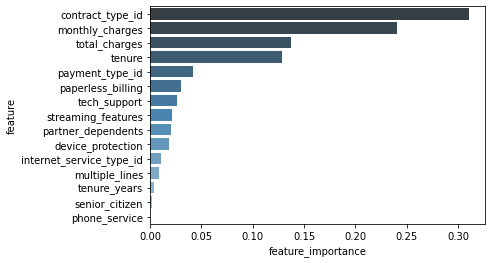

In [71]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")

Overall, we see that the model is doing fairly well at predicting values when the positive is `not_churning`. While this is good, this is not what we are looking for, as we want to predict the probability that a customer will churn. The precision and recall values are still good when we look at churning as the positive, but they need to be substancially imporved, as failing to accurately predict if a customer will churn can cost the company significant money.

### Random Forest

In [72]:
telco = acquire.read_telco_data()

In [73]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [74]:
for i in range(1,26):
    rf, y_pred = model.run_rf(X_train, y_train, 1, i)
    print(f'max_depth = {i}, train_accuracy = {rf.score(X_train, y_train):.2%}, diff_accuracy = {(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))/rf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 77.33%, diff_accuracy = -2%
max_depth = 3, train_accuracy = 78.89%, diff_accuracy = -3%
max_depth = 4, train_accuracy = 79.10%, diff_accuracy = -3%
max_depth = 5, train_accuracy = 79.86%, diff_accuracy = -1%
max_depth = 6, train_accuracy = 80.47%, diff_accuracy = -1%
max_depth = 7, train_accuracy = 81.85%, diff_accuracy = 1%
max_depth = 8, train_accuracy = 83.46%, diff_accuracy = 3%
max_depth = 9, train_accuracy = 85.63%, diff_accuracy = 6%
max_depth = 10, train_accuracy = 87.88%, diff_accuracy = 11%
max_depth = 11, train_accuracy = 90.86%, diff_accuracy = 13%
max_depth = 12, train_accuracy = 92.97%, diff_accuracy = 18%
max_depth = 13, train_accuracy = 94.79%, diff_accuracy = 19%
max_depth = 14, train_accuracy = 96.24%, diff_accuracy = 23%
max_depth = 15, train_accuracy = 96.69%, diff_accuracy = 22%
max_depth = 16, train_accuracy = 97.68%, diff_accuracy = 24%
max_depth = 17, train_accuracy = 97.

In [153]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 10)
evaluation["random_forest_model"] = y_pred

In [154]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

In [155]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.88
      0    1
0  2891  205
1   320  809


,0,1,accuracy,macro avg,weighted avg
precision,0.900343,0.797830,0.87574,0.849086,0.872949
recall,0.933786,0.716563,0.87574,0.825174,0.875740
f1-score,0.916759,0.755016,0.87574,0.835888,0.873538
support,3096.000000,1129.000000,0.87574,4225.000000,4225.000000


In [78]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers

''')


The model accurately predicted 940 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $69,609 by not loosing those customers




In [157]:
y_pred = rf.predict(X_validate)
print(classification_report(y_pred, y_validate))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1101
           1       0.54      0.62      0.58       308

    accuracy                           0.80      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.81      0.80      0.81      1409



In [80]:
coef = rf.feature_importances_
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

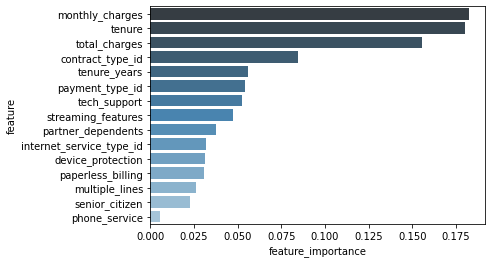

In [81]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")

The random forest model proves to be slightly better than the decision tree model. It has better recall and precision when it comes to predicting churn as the positive value, however, it still has much better predictive scores when looking at predicting customers that will not churn. I suspect that some of the current features are actually creating an bias, leading the model to inaccurately predict some values. 

In terms of the most important coefficients, `tenure`, `monthly_charges`, and `total_charges` are tied for most important featues, `contract_type_id` is also still fairly important.

### KNN

In [82]:
telco = acquire.read_telco_data()
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [83]:
for k in range(1,25):
    knn, y_pred = model.run_knn(X_train, y_train, k)
    print(f'max_depth = {k}, train_accuracy = {knn.score(X_train, y_train):.2%}, diff_accuracy = {(knn.score(X_train, y_train) - knn.score(X_validate, y_validate))/knn.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 99.72%, diff_accuracy = 39%
max_depth = 2, train_accuracy = 86.13%, diff_accuracy = 12%
max_depth = 3, train_accuracy = 86.25%, diff_accuracy = 12%
max_depth = 4, train_accuracy = 84.12%, diff_accuracy = 8%
max_depth = 5, train_accuracy = 83.10%, diff_accuracy = 7%
max_depth = 6, train_accuracy = 81.85%, diff_accuracy = 4%
max_depth = 7, train_accuracy = 81.28%, diff_accuracy = 3%
max_depth = 8, train_accuracy = 81.44%, diff_accuracy = 2%
max_depth = 9, train_accuracy = 81.02%, diff_accuracy = 2%
max_depth = 10, train_accuracy = 80.99%, diff_accuracy = 1%
max_depth = 11, train_accuracy = 80.57%, diff_accuracy = 0%
max_depth = 12, train_accuracy = 80.69%, diff_accuracy = -1%
max_depth = 13, train_accuracy = 80.64%, diff_accuracy = -1%
max_depth = 14, train_accuracy = 80.80%, diff_accuracy = -0%
max_depth = 15, train_accuracy = 80.66%, diff_accuracy = 0%
max_depth = 16, train_accuracy = 80.62%, diff_accuracy = -0%
max_depth = 17, train_accuracy = 80.26%, d

In [84]:
knn, y_pred = model.run_knn(X_train, y_train, 2)
evaluation["knn_model"] = y_pred

In [85]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)

In [86]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.86
      0    1
0  3095    1
1   585  544


,0,1,accuracy,macro avg,weighted avg
precision,0.841033,0.998165,0.861302,0.919599,0.883021
recall,0.999677,0.481842,0.861302,0.740760,0.861302
f1-score,0.913518,0.649940,0.861302,0.781729,0.843085
support,3096.000000,1129.000000,0.861302,4225.000000,4225.000000


In [87]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')


The model accurately predicted 544 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $40,285 by not loosing those customers





In [88]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      3096
           1       1.00      0.48      0.65      1129

    accuracy                           0.86      4225
   macro avg       0.92      0.74      0.78      4225
weighted avg       0.88      0.86      0.84      4225



KNN has an increadible precision score, but misses 50% of the cases when it comes to recall. For this particular case, we want to make sure that our recall is as high as possible, becasue we want to minimize the number of False Negatives. The reason for this is that in this case, we can either predict a customer will not churn, and then they churn - that's an expensive loss. While the opposite, would be we predict that a customer will churn, when they likely weren't. While we still want to maximize reasources and time to target customers that are likely to churn, it is more expensive (in terms of potential dollars) if our model has more false negatives. 

In [159]:
for i in range(0,6):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    print(f'{evaluation.columns[i]} = {report.accuracy[0]:.2f}')

actual = 1.00
baseline = 0.73
logistic_regression_1 = 0.80
decision_tree_model = 0.85
random_forest_model = 0.88
knn_model = 0.86


In [160]:
for i in range(0,6):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    print(f'{evaluation.columns[i]} recall = {report["1"][1]:.2f}')

actual recall = 1.00
baseline recall = 0.00
logistic_regression_1 recall = 0.53
decision_tree_model recall = 0.72
random_forest_model recall = 0.72
knn_model recall = 0.48


## Conclusion

At this point, the random forest model seems to be the best model. The reason for that is because it has the highest recall. It also has the highest overall average for precision and recall, which is something we need for this case. I believe that some of the features might need to be encoded with `OneHotEncoder`, because they are throwing the models off. I suspect this is the case becasue the continuous features are consistently getting higher influence than what we predicted during the exploration face. Additionally, becasue we used `LabelEncoders` on features that aren't necesarily booleans, then the models might be giving more weight to some features just becasue they have a higher number. At this point, I suggest going back to the data prep and encoding these features.

# Modeling II

After the first round of modeling - we have now learned that the models are performing well - but I want to try to improve them by doing some feature engineering.

1. Create OneHotEncoder 
2. Run through the models again
3. Evaluate

In [91]:
telco = acquire.read_telco_data()
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [92]:
X_train.shape[1] == X_validate.shape[1]

True

In [93]:
X_train.head()

,senior_citizen,tenure,multiple_lines,paperless_billing,monthly_charges,total_charges,partner_dependents,streaming_features,online_features,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Month-to-month,One year,Two year,DSL,Fiber optic,None
440,0,0.097222,0,0,0.517920,516.15,3,3,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
67,0,0.013889,0,1,0.365977,54.65,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
600,0,0.041667,0,0,0.353357,188.70,0,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4883,0,0.916667,1,1,0.848561,6615.15,3,3,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1258,0,0.861111,0,1,0.528521,4263.45,3,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Modeling

### Logistic Regression

In [94]:
telco = acquire.read_telco_data()

In [95]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [96]:
logict, y_pred = model.run_lg(X_train, y_train)
evaluation["logistic_regression_2"] = y_pred

In [97]:
accuracy_score, matrix, report = model.accuracy_report(logict, y_pred, y_train)

In [98]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.80
      0    1
0  2776  320
1   535  594


,0,1,accuracy,macro avg,weighted avg
precision,0.838417,0.649891,0.797633,0.744154,0.788039
recall,0.896641,0.526129,0.797633,0.711385,0.797633
f1-score,0.866552,0.581498,0.797633,0.724025,0.790380
support,3096.000000,1129.000000,0.797633,4225.000000,4225.000000


In [99]:
logict.coef_[0]

array([ 1.93675908e-01, -1.01107879e+00,  1.85105549e-01,  4.49055358e-01,
        3.35458672e-01, -1.26862068e-04, -7.73555022e-02,  1.61754993e-01,
       -1.90869751e-01, -3.22703174e-01, -4.92974932e-01,  7.37973883e-02,
       -1.61032294e-01,  5.28900730e-01, -3.83299391e-01, -1.04851435e+00,
       -4.34503604e-01,  4.61187533e-01, -9.29596941e-01])

In [100]:
coef = logict.coef_[0]
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == X_train.shape[1])
coef = logict.coef_[0]
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'Which feature is most important')

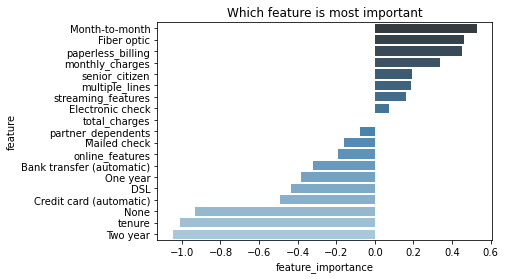

In [101]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("Which feature is most important")

### Decision Tree

In [102]:
for i in range(1,26):
    clf, y_pred = model.run_clf(X_train, y_train, i)
    print(f'max_depth = {i}, train_accuracy = {clf.score(X_train, y_train):.2%}, diff_accuracy = {(clf.score(X_train, y_train) - clf.score(X_validate, y_validate))/clf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 75.81%, diff_accuracy = -1%
max_depth = 3, train_accuracy = 78.65%, diff_accuracy = -2%
max_depth = 4, train_accuracy = 79.31%, diff_accuracy = -2%
max_depth = 5, train_accuracy = 79.83%, diff_accuracy = -1%
max_depth = 6, train_accuracy = 80.90%, diff_accuracy = 2%
max_depth = 7, train_accuracy = 81.94%, diff_accuracy = 3%
max_depth = 8, train_accuracy = 82.93%, diff_accuracy = 7%
max_depth = 9, train_accuracy = 84.40%, diff_accuracy = 9%
max_depth = 10, train_accuracy = 85.63%, diff_accuracy = 11%
max_depth = 11, train_accuracy = 87.60%, diff_accuracy = 16%
max_depth = 12, train_accuracy = 89.18%, diff_accuracy = 19%
max_depth = 13, train_accuracy = 90.60%, diff_accuracy = 21%
max_depth = 14, train_accuracy = 92.59%, diff_accuracy = 27%
max_depth = 15, train_accuracy = 93.92%, diff_accuracy = 29%
max_depth = 16, train_accuracy = 94.86%, diff_accuracy = 32%
max_depth = 17, train_accuracy = 95.7

In [209]:
clf, y_pred = model.run_clf(X_train, y_train, 7)
evaluation["clf_2"] = y_pred

In [210]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)

In [211]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.82
      0    1
0  2748  348
1   415  714


,0,1,accuracy,macro avg,weighted avg
precision,0.868795,0.672316,0.819408,0.770556,0.816293
recall,0.887597,0.632418,0.819408,0.760007,0.819408
f1-score,0.878096,0.651757,0.819408,0.764926,0.817614
support,3096.000000,1129.000000,0.819408,4225.000000,4225.000000


In [106]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')


The model accurately predicted 889 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $65,833 by not loosing those customers





In [212]:
y_pred = clf.predict(X_validate)
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_validate)
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.79
     0    1
0  918  135
1  157  199


,0,1,accuracy,macro avg,weighted avg
precision,0.853953,0.595808,0.792761,0.724881,0.788730
recall,0.871795,0.558989,0.792761,0.715392,0.792761
f1-score,0.862782,0.576812,0.792761,0.719797,0.790528
support,1053.000000,356.000000,0.792761,1409.000000,1409.000000


In [107]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3096
           1       0.80      0.79      0.80      1129

    accuracy                           0.89      4225
   macro avg       0.86      0.86      0.86      4225
weighted avg       0.89      0.89      0.89      4225



In [108]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == X_train.shape[1])
coef = clf.feature_importances_
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'Which feature is most important')

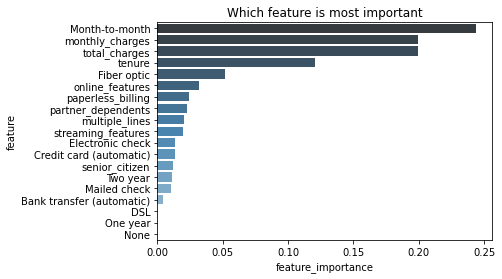

In [109]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("Which feature is most important")

In [110]:
print(classification_report(evaluation.decision_tree_model, evaluation.actual))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3114
           1       0.72      0.73      0.72      1111

    accuracy                           0.85      4225
   macro avg       0.81      0.81      0.81      4225
weighted avg       0.85      0.85      0.85      4225



We can see that the model is doing better with the new features. Overall, our recall score improved by 6%, which is a good imporvement. Despite what see saw in the exploration phase, it seems that `monthly_charges` are the most influencial coefficient. I think the encoding definitively helped, because know we know that out of the contract types, Month-to-month is the biggest indicator of churn, which we did observed duing the exploration phase.`Tenure` is the third most important feature, which makes sense. 

### Random Forest

In [174]:
telco = acquire.read_telco_data()
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [177]:
for i in range(1,20):
    rf, y_pred = model.run_rf(X_train, y_train, 5, i)
    print(f'max_depth = {i}, train_accuracy = {rf.score(X_train, y_train):.2%}, diff_accuracy = {(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))/rf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 77.23%, diff_accuracy = -1%
max_depth = 3, train_accuracy = 78.56%, diff_accuracy = -2%
max_depth = 4, train_accuracy = 79.10%, diff_accuracy = -2%
max_depth = 5, train_accuracy = 79.60%, diff_accuracy = -2%
max_depth = 6, train_accuracy = 80.80%, diff_accuracy = -1%
max_depth = 7, train_accuracy = 81.37%, diff_accuracy = -1%
max_depth = 8, train_accuracy = 82.46%, diff_accuracy = 1%
max_depth = 9, train_accuracy = 83.12%, diff_accuracy = 2%
max_depth = 10, train_accuracy = 83.64%, diff_accuracy = 3%
max_depth = 11, train_accuracy = 84.28%, diff_accuracy = 4%
max_depth = 12, train_accuracy = 84.99%, diff_accuracy = 5%
max_depth = 13, train_accuracy = 84.88%, diff_accuracy = 4%
max_depth = 14, train_accuracy = 85.16%, diff_accuracy = 5%
max_depth = 15, train_accuracy = 85.21%, diff_accuracy = 6%
max_depth = 16, train_accuracy = 85.21%, diff_accuracy = 4%
max_depth = 17, train_accuracy = 85.18%, d

In [225]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 8)
evaluation["rf_2"] = y_pred

In [226]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.84
      0    1
0  2822  274
1   420  709


,0,1,accuracy,macro avg,weighted avg
precision,0.870450,0.721261,0.83574,0.795856,0.830584
recall,0.911499,0.627989,0.83574,0.769744,0.835740
f1-score,0.890502,0.671402,0.83574,0.780952,0.831954
support,3096.000000,1129.000000,0.83574,4225.000000,4225.000000


In [116]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')


The model accurately predicted 723 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $53,540 by not loosing those customers





In [117]:
coef = rf.feature_importances_
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

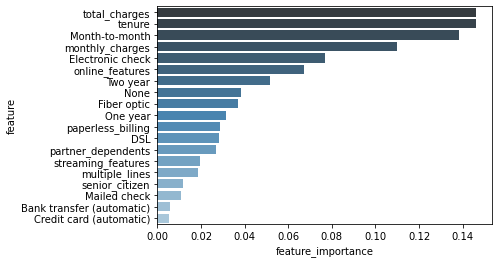

In [118]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")

In [227]:
y_pred = rf.predict(X_validate)
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_validate)

print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.82
     0    1
0  954   99
1  154  202


,0,1,accuracy,macro avg,weighted avg
precision,0.861011,0.671096,0.82044,0.766054,0.813027
recall,0.905983,0.567416,0.82044,0.736699,0.820440
f1-score,0.882925,0.614916,0.82044,0.748920,0.815209
support,1053.000000,356.000000,0.82044,1409.000000,1409.000000


The random forest also saw an improvement in performance. Both random forest model though are at most risk of overfitting, as they both have about 20% difference in accuracy scores between the test data and the validate data. This is something that we need to keep in mind before evaluation, as it can be a problem. That problem aside, however, the Random Forest model performs better than all of our previous models. 

It takes `monthly_charges` and `tenure` as it's two most important coefficients, and `online_features` is thrd. Overall, the model doesn't seem to need as much the HotEncoded items, but it performs better by having them none the less

## KNN

In [120]:
telco = acquire.read_telco_data()
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [121]:
for k in range(1,25):
    knn, y_pred = model.run_knn(X_train, y_train, k)
    print(f'max_depth = {k}, train_accuracy = {knn.score(X_train, y_train):.2%}, diff_accuracy = {(knn.score(X_train, y_train) - knn.score(X_validate, y_validate))/knn.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 99.74%, diff_accuracy = 40%
max_depth = 2, train_accuracy = 84.73%, diff_accuracy = 11%
max_depth = 3, train_accuracy = 84.52%, diff_accuracy = 15%
max_depth = 4, train_accuracy = 81.70%, diff_accuracy = 7%
max_depth = 5, train_accuracy = 81.68%, diff_accuracy = 10%
max_depth = 6, train_accuracy = 79.91%, diff_accuracy = 4%
max_depth = 7, train_accuracy = 79.57%, diff_accuracy = 5%
max_depth = 8, train_accuracy = 78.46%, diff_accuracy = 3%
max_depth = 9, train_accuracy = 78.30%, diff_accuracy = 3%
max_depth = 10, train_accuracy = 77.99%, diff_accuracy = 2%
max_depth = 11, train_accuracy = 78.46%, diff_accuracy = 3%
max_depth = 12, train_accuracy = 77.63%, diff_accuracy = 1%
max_depth = 13, train_accuracy = 77.37%, diff_accuracy = 1%
max_depth = 14, train_accuracy = 77.11%, diff_accuracy = 1%
max_depth = 15, train_accuracy = 77.28%, diff_accuracy = 2%
max_depth = 16, train_accuracy = 76.78%, diff_accuracy = 0%
max_depth = 17, train_accuracy = 77.14%, diff

In [122]:
knn, y_pred = model.run_knn(X_train, y_train, 2)
evaluation["knn_model_2"] = y_pred

In [123]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)

In [124]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.85
      0    1
0  3093    3
1   642  487


,0,1,accuracy,macro avg,weighted avg
precision,0.828112,0.993878,0.847337,0.910995,0.872408
recall,0.999031,0.431355,0.847337,0.715193,0.847337
f1-score,0.905578,0.601606,0.847337,0.753592,0.824351
support,3096.000000,1129.000000,0.847337,4225.000000,4225.000000


In [125]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')


The model accurately predicted 487 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $36,064 by not loosing those customers





With just a superficial look, I can already tell that our KNN model does not perform much better. It might be that because the majority of points are not likely to churn, they are more likely to be clumped together, which is why the model is doing so well at predicting the negative case (not_churn), but it is struggling at accurately predicting the positive value. The model does have a perfect recall score (which inherently worries me) but it only scores about 50% on the precision score, which is too low for us to use effectively.


In [135]:
# How do the different models compare on accuracy?
for i in range(0,10):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    print(f'{evaluation.columns[i]} = {report.accuracy[0]:.2f}')

actual = 1.00
baseline = 0.73
logistic_regression_1 = 0.80
decision_tree_model = 0.85
random_forest_model = 0.93
knn_model = 0.86
logistic_regression_2 = 0.80
clf_2 = 0.89
rf_2 = 0.85
knn_model_2 = 0.85


In [201]:
# How do the models compare on recall?
for i in range(0,10):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    print(f'{evaluation.columns[i]} recall = {report["1"][1]:.2f}')

actual recall = 1.00
baseline recall = 0.00
logistic_regression_1 recall = 0.53
decision_tree_model recall = 0.72
random_forest_model recall = 0.72
knn_model recall = 0.48
logistic_regression_2 recall = 0.53
clf_2 recall = 0.79
rf_2 recall = 0.63
knn_model_2 recall = 0.43


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Test

# Conclusion 

At this point, my recommendation would be to use Random Forest, with the scaled and econded features (rf_2). Despite not performing significantly better than the rest of the models, and having a slightly smaller recall than our original random_forest_model, it has the highest recall and precision scores, collectively. I also think that the second phase models are better, because they avoid using features that have a strong correlation with `monthly_charges`, which is the most important coefficient in all the models. The encoded columns also lets us get further insight into what specific varibles within `contract_type` and `internet_type` are most influencial when it comes to predicting churn. We will know look to do a final evaluation by looking at the test data for the first time. The objective is to ensure that the Random Forest model is not overfit, and will work well with new data. Given that our current model does have a big difference in performance (~20%) between the train and the variance data, it is on the edge of being overfit.Important to note, all models perform better than the baseline in predicting customers that are likely to churn. This means that any of our model, if deployed, would be more effective than just using the baseline as a prediction.

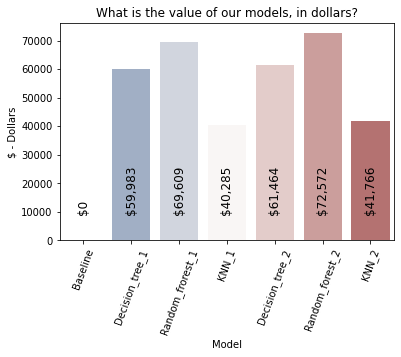

In [128]:
# Create a new list of lists containing the model's name, and the calculated value, in dollars, for the model.
data = [["Baseline", 0],["Decision_tree_1", 59983], ["Random_frorest_1", 69609], ["KNN_1",40285], ["Decision_tree_2",61464], ["Random_forest_2",72572], ["KNN_2",41766]]

# Turn the list into a DF
df = pd.DataFrame(data, columns=["Model", "Dollars"])

# Plot the df using seaborn
sns.barplot(data=df, x="Model", y="Dollars", palette="vlag")
plt.xticks(rotation=70)
plt.title("What is the value of our models, in dollars?")
plt.ylabel("$ - Dollars")
# Use a loop to populate the text values
for i in range(len(df)):
    plt.text(i,10000,f'${df.Dollars[i]:,}',color = "black", fontsize=12, ha="center", rotation=90)

As we can see - our prefered mode, Random_forest_2 outperforms all the other models when it comes to accurately predicting customers that will churn. With this model, we can be far more effective in targeting these customers with our CRM systems, and if we can retain most of them, can help the company make over $70,000 in additional revenue by reducing the number of customers that are churning.

# Suggestions and Key-takeaways:

Every time that a customer leaves, we lose potential revenue. Given that it is up to 10 times more expensive to acquire new customers than it is to retain them, our objective should be to minize churn, in order to increase revenue. Our Random Forest model can help identify potential customers that are likely to churn.

Based on our analysis, we suspect the main driving force in customers churning is price. In our testing we saw that, on average, customers that churn did have a higher monthly charges over customers that didn't churn. 

Our main suggestion is to use our model and target customers that have a high probability of churning by offering them discounts on their subscriptions, either by offering some of the premium products at a cheaper price, or lowering the cost of their base plan. This might seem like it would lower income in the short run, but by lowering our churn rate, we will be able to greatly increase our revenue.